# Generador de Recetas

En este notebook vamos a mostrar como se puede usar los datos en el archivo 'Recetas.cvs' para generar nuevos tipos de recetas. 

In [8]:
# import numpy as np
%pylab
import pandas as pd
import networkx as nx
import pygraphviz

from IPython.display import Image

import seaborn as sns
import itertools
from collections import OrderedDict
from collections import Counter
from networkx.algorithms import approximation as apxa
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from sklearn import cluster
import random
import numpy as np
# from networkx.algorithms.community import k_clique_communities
from collections import defaultdict
from matplotlib import colors
import nltk

rcParams.update({'font.size': 23})
rc("text", usetex = True)
rc("font", family = "serif")
rcParams['figure.subplot.hspace'] = 0.3
rcParams['figure.subplot.wspace'] = 0.1
mpl.rcParams['lines.linewidth'] = 4

sns.set(style='whitegrid', palette='muted',rc={'figure.figsize': (8,6)})
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"



## Deficinición de Receta

El primer paso para entender ccom vamos a solucionar el problema es definir lo que vamos a entender por receta.

### Una receta es una serie de pasos donde cada uno de estos pasos puede involucrar cero o muchos ingredientes, y cada ingredient tiene una cantidad específica.

Este tipo de situaciones se puede graficar como un árbol, como el que se ve en la siguiente figura. 

    - (Azul) En la cima de la pirámide vamos a colocar el tipo de la receta. Este nodo va estar conectado con el primer paso. Ej: Tipo = 'Postre'
    - (Rojo) Cada paso puede estar conectado con cero o varios ingredientes y está conectado con un posible siguiente paso.  Ej: Hornear, Mezclar
    - (Verde) Cada ingrediente está asociado a un paso y a una cantidad específica. Ej: Aceite de oliva
    - (Amarillo) Cada ingrediente está asociado a una cantidad. Ej: 3 onzas
 
Enteder las recetas de esta forma nos va a permitir dar una explicación sistemática a los datos que poseemos al igual que generar recetas de forma más simple.   




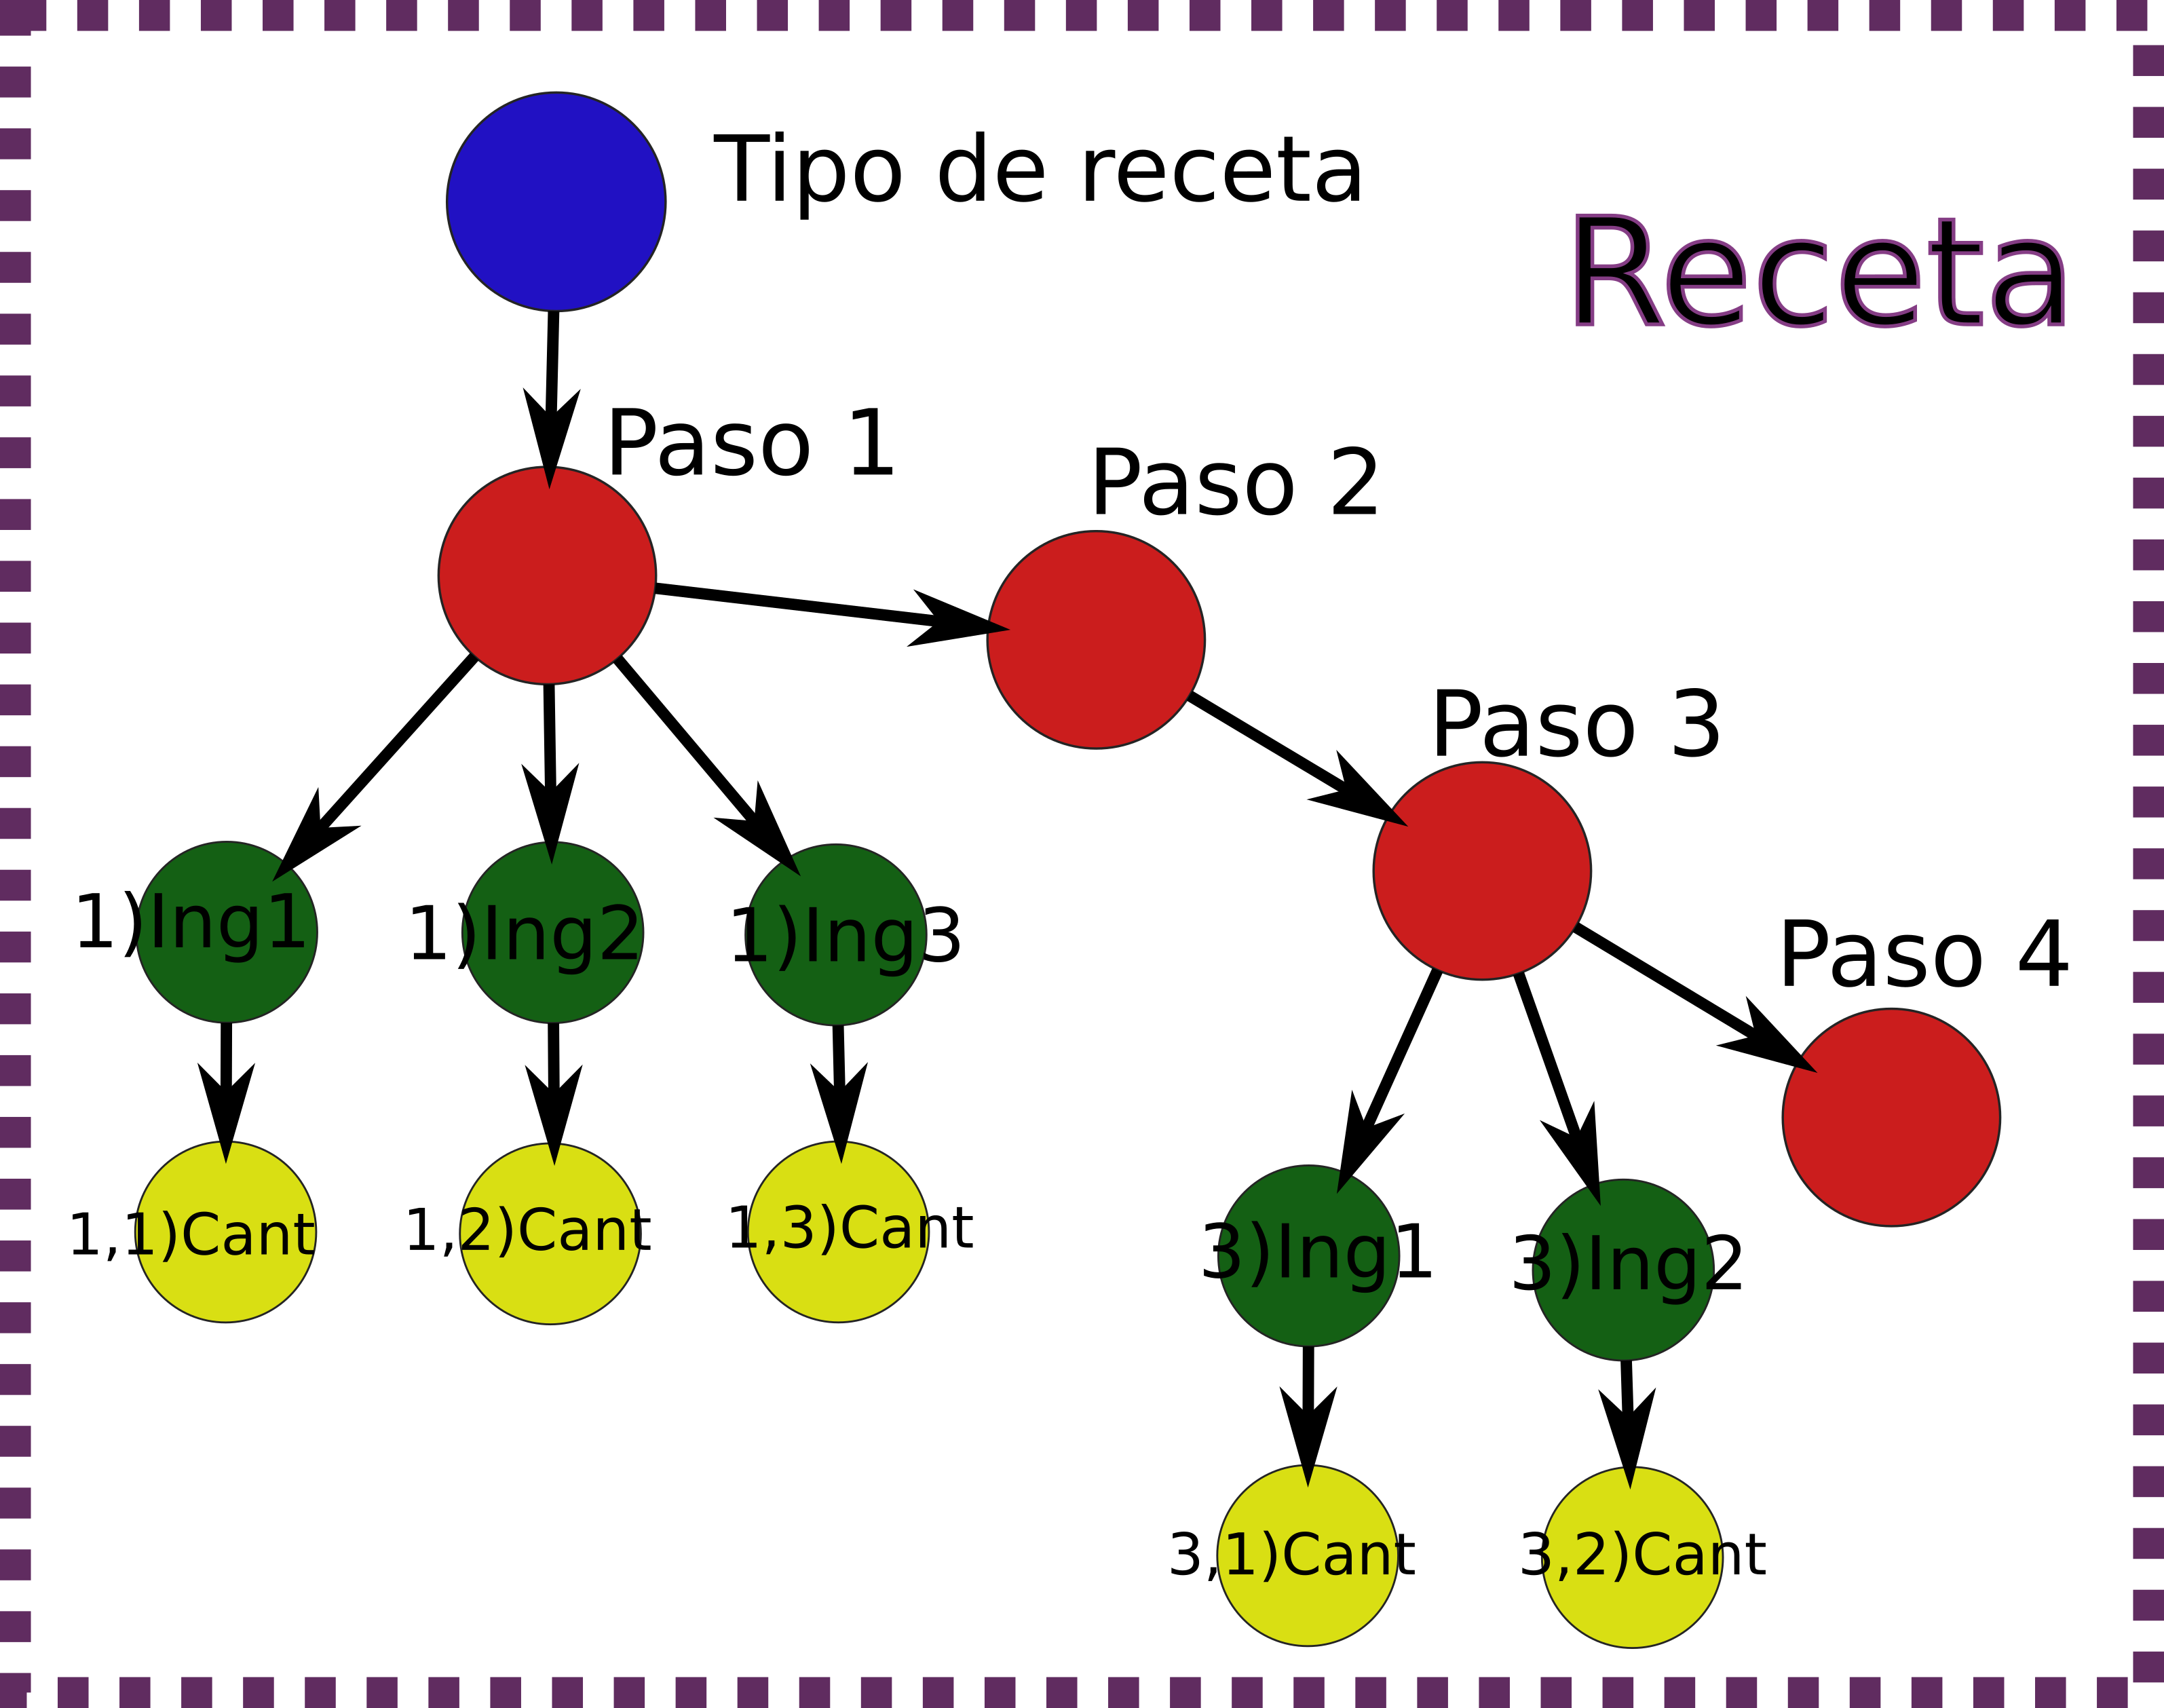

In [9]:
Image("receta.png")

## Limpieza de datos

Antes de comenzar a generar las recetas, creamos un algoritmo que premite limpiar el dataset Recetas.cvs. 

El dataset recibido contiene numerosos detalles que pueden causar un problemas ne el código:

    1. Filas con títulos y Categoría vacía: Estos datos son inconsistentes y van a ser eliminados
    2. Columnas comenzando por '_' o finalizando en 'asterisco' y 'condición': contienen datos irrelevantes
    3. Las columnas de ingredientes , pasos, entre otras , repinten información después del caracter '|'


In [10]:
df = pd.read_csv('Recetas.csv', delimiter = ';')
df.head().T

,0,1,2,3,4
ID,35,NaN,c14826c1ec|field_56fc14826c1ec|field_56fc14826...,36,NaN
Title,Pollo Cancún,NaN,Fécula de maíz|Fécula de maíz|Fécula de maíz|F...,Paletas heladas caribeñas de crema,NaN
Content,NaN,NaN,field_56fc14a26c1ed|field_56fc14a26c1ed|field_...,NaN,NaN
Excerpt,NaN,NaN,0,NaN,NaN
URL,NaN,NaN,NaN,NaN,NaN
Categories,Recetas,NaN,NaN,Recetas,NaN
Tags,Aceite de oliva|Cena|Cilantro|Fruta tropical|P...,NaN,NaN,Fruta tropical|Mango|Miel|Papaya|Postre|Queso ...,NaN
pasos_0_descripcion_del_paso,<b>Aplana</b> el pollo hasta obtener un grosor...,NaN,NaN,<b>Mide</b> 2 tazas de fruta DOLE sin el jugo....,NaN
pasos_1_descripcion_del_paso,<b>Calienta</b> el aceite de oliva en la sarté...,NaN,NaN,<b>Mezcla</b> en una licuadora o procesador de...,NaN
ingredientes_0_cantidad,4 rebanadas|4 rebanadas|4 rebanadas|4 rebanada...,NaN,NaN,1 frasco (23.5 oz)|1 frasco (23.5 oz)|1 frasco...,NaN


In [11]:
#If columns matches with the ending of x, eliminates the repeated patterns in x. 
#    Returns df. with a new column having the cleaned data 
def EliminateRepeated(df, x, column):
    if x.endswith(column) :
            #Separate strings by '|'.
            vecs = df[x].str.split(pat = "|",expand=True)  #vecs is the number of divisions of the df[x]
            num = x.split('_') ; num = num[1]  #get number of column
            df[column.upper()+'_'+ num] = vecs[0]  #create new column with the ingredient
            #Add another ingredient to the columns if there is a diferent value in one of them 
            if 1 in vecs:
                condition = ((vecs[0].notnull()) 
                            & (vecs[1].notnull())
                            & (vecs[0] != vecs[1]) )
                #if the new column provides different results, add the next column with a comma between the values            
                df.loc[condition, column.upper()+'_'+ num ] = (vecs.loc[condition, 0]  
                                                              + ','
                                                              + vecs.loc[condition, 1]) 
            del df[x] #finish eliminating df[x], now that the information have been saved in df[x.upper()+'_'+ num] 
    return df      


# Cleans the columns of ingrediente, cantidad and paso
def cleanData(df): 
    df =  df.loc[df.Categories == 'Recetas']
    df = df[df.Title.notnull()]
    
    del df['Content']
    del df['Excerpt']
    del df['URL']
    
    for x in df.columns:
        #eliminate vacum columns
        if df[x].count() < 1:
            del df[x]
        elif x.startswith('_'):
            del df[x]
    for x in df.columns:
        #Eliminate repeated terms in 'ingredientes', 'cantidades' and 'pasos'
        EliminateRepeated(df, x, 'ingrediente')
        EliminateRepeated(df, x, 'cantidad')
        EliminateRepeated(df, x, 'paso')
    return df       

#Fills null values with  empty strings
#FIND POSSIBLE MISLEADING VALUES ON THE DATA SET AND REPLACE THEM BY NOTHING
def replaceValues(df, x):
    df[x] = df[x].fillna(value = '')
    df[x] = df[x].str.replace('<strong>' , '' )
    df[x] = df[x].str.replace('</strong>' , ':' )
    df[x] = df[x].str.replace('</b>' , ':' )
    df[x] = df[x].str.replace('®' , '' )
    df[x] = df[x].str.replace('<br>' , ':' )
    df[x] = df[x].str.replace('<sup>®</sup>' , '' )
    df[x] = df[x].str.replace('<sup></sup>' , '' )
    df[x] = df[x].str.replace('<sup>®</sup>' , '' )
    df[x] = df[x].str.replace('®' , '' )
    df[x] = df[x].str.replace('<b>' , '' )
    df[x] = df[x].str.replace('<i>' , '' )
    df[x] = df[x].str.replace('</i>' , '' )
    df[x] = df[x].str.replace(')' , '' )
    df[x] = df[x].str.replace('(' , '' )
    df[x] = df[x].str.replace('?' , '' )
    df[x] = df[x].str.replace('¿' , '' )
    df[x] = df[x].str.replace('¡' , '' )
    df[x] = df[x].str.replace('!' , '' )
    df[x] = df[x].str.replace('/' , '' )
    return df[x]
df = pd.read_csv('Recetas.csv', delimiter = ';')
df[{'Title','Categories'}].loc[df.Categories == 'Recetas'].count()
df = cleanData(df)

## Tipo de Receta

El tipo es un atributo esencial de cada receta que clasífica las recetas como:
    - Desayuno
    - Postre
    - Plato Fuerte
    - Entrada
    - Bebida

Para determinar esta información en esta vamos a usar la columna 'Tags' la cual contiene palabras clave como 'postre,cena , bebida, etc' que nos permitira asociar rápidamente la receta con el tipo de plato. 

In [12]:
def definirTipo(df):
    df['Tags']  = df.Tags.str.lower()
    #Definir tipo de acuerdo a la aparicion de palabras claves en los TAGS
    df['Tipo'] = ''
    
    df.loc[df.Tags.str.contains(pat = 'desayuno'), 'Tipo' ] = 'Desayuno'
    
    df.loc[ df.Tags.str.contains(pat = 'postre'), 'Tipo' ] = 'Postre'
    df.loc[ df.Tags.str.contains(pat = 'dulce'), 'Tipo' ] = 'Postre'
    df.loc[ df.Tags.str.contains(pat = 'helado'), 'Tipo' ] = 'Postre'
    df.loc[ df.Tags.str.contains(pat = 'torta'), 'Tipo' ] = 'Postre'
    df.loc[ df.Tags.str.contains(pat = 'cheesecake'), 'Tipo' ] = 'Postre'
    df.loc[ df.Tags.str.contains(pat = 'glasé'), 'Tipo' ] = 'Postre'
    df.loc[ df.Tags.str.contains(pat = 'chocolate'), 'Tipo' ] = 'Postre'


    df.loc[ df.Tags.str.contains(pat = 'cena'), 'Tipo' ] = 'PlatoFuerte'
    df.loc[df.Tags.str.contains(pat = 'almuerzo'), 'Tipo' ] = 'PlatoFuerte'
    df.loc[df.Tags.str.contains(pat = 'tacos'), 'Tipo' ] = 'PlatoFuerte'
    

    df.loc[df.Tags.str.contains(pat = 'aperitivos'), 'Tipo' ] = 'Entrada'
    df.loc[df.Tags.str.contains(pat = 'acompañamiento'), 'Tipo' ] = 'Entrada'
    df.loc[df.Tags.str.contains(pat = 'tostada'), 'Tipo' ] = 'Entrada'

    df.loc[df.Tags.str.contains(pat = 'bebida'), 'Tipo' ] = 'Bebida'
    df.loc[df.Tags.str.contains(pat = 'cóctel'), 'Tipo' ] = 'Bebida'
   

    #If empty , it is likely to be an entry
    df.loc[df.Tipo == '', 'Tipo' ] = 'Entrada' 
    return df


df = definirTipo(df)
print(df['Tipo'].value_counts())
df[['Title','Tipo','Tags']].sample(7)

Postre         30
Entrada        24
Bebida         23
PlatoFuerte    17
Desayuno        2
Name: Tipo, dtype: int64


,Title,Tipo,Tags
60,Margarita de piña,Bebida,cóctel|delicioso|dulzura|frappé|margarita|piña...
43,Granita escarchada de piña y jengibre,Postre,delicioso|fácil|granita|helado|jengibre|jugo d...
100,Pollo con Piña,Entrada,bolivia|cebollas|piña|pollo|rebanadas de piña|ron
32,Glasé de piñas para el pan de muerto,Postre,azúcar|glasé|pan de muerto|piña|simple
81,Burritos de vegetales asados,Entrada,berenjena|burrito|calabacín|calabacita|cebolla...
56,Torta cítrica fría con piñas y galletas María,Postre,pastel|piña|postre|rica|sencilla|torta|tropical
64,Ponche de ron con piña y menta,Bebida,bebida|jengibre|menta|navidad|piña|ponche|ron|...


## Datos Relevantes

Gracias a una limpieza efectiva del archivo, hemos encontrado que los datos más relevantes se encuentran en las columnas 
1. Title
2. Tipo
3. Tags
4. Ingredientes
5. Pasos
6. Cantidad


In [14]:
# Clean the cvs_file 
# Gets the relevant columns and saves them into df and into the file  'CleanedData.csv'
def cleanCVS(cvs_file):
    df = pd.read_csv(cvs_file, delimiter = ';')
    df[{'Title','Categories'}].loc[df.Categories == 'Recetas'].count()
    #Apply previous methods
    df = cleanData(df)
    df = definirTipo(df)
    
    s = ['Title','Tipo', 'Tags']
    df['Tags'] = df['Tags'].str.replace('|' , ' , ' )

    del df['PASO_nombre']
    del df['PASO_descripcion']
    del df['CANTIDAD_cantidad']
    del df['INGREDIENTE_ingrediente']


    for x in df.columns:
        if x.startswith('INGREDIENTE') :
            df[x] = replaceValues(df, x)
            s.append(x)

    for x in df.columns:
         if x.startswith('PASO') :
            df[x] = replaceValues(df, x)
            s.append(x)
              

    for x in df.columns:
         if x.startswith('CANTIDAD') :
            df[x] = replaceValues(df, x)
            s.append(x)

    df[s].T
    df[s].to_csv('CleanedData.csv')
    return df[s]
df= cleanCVS('Recetas.csv')

In [15]:
display_all(df.describe(include='all').T)
df.sample(5).T

,count,unique,top,freq
Title,96,95,Torta invertida de piña y queso crema,2
Tipo,96,5,Postre,30
Tags,96,96,"aceitunas , delicioso , esponjosa , pan de jam...",1
INGREDIENTE_0,96,71,,21
INGREDIENTE_1,96,64,,22
INGREDIENTE_2,96,68,,23
INGREDIENTE_3,96,62,,26
INGREDIENTE_4,96,48,,45
INGREDIENTE_5,96,42,,51
INGREDIENTE_6,96,36,,58


,66,61,91,51,98
Title,Caipiriña de piña,Ensalada Latina de Piña Para LLevar,"Margarita picante de piña, sin azúcar",Sangría navideña,Flan de Piña
Tipo,Bebida,Postre,Bebida,Bebida,Postre
Tags,"bebida , caipirinha , cóctel , espumosa , lico...","aguacate , berro , crujiente , cubana , dulce ...","bebida alcohólica , chile , jalapeño , jugo de...","bebidas , brandy , celebración , deliciosa , f...","almidón , ecuador , flan , latinoamérica , lec..."
INGREDIENTE_0,Cachaza,,Condimento chile y limón,"Mezcla de frutas DOLE, parcialmente descongeladas",
INGREDIENTE_1,Azúcar morena,,Jugo de piña DOLEPineapple Juice,Brandy,
INGREDIENTE_2,Lima exprimida,,Tequila blanco,Azúcar,
INGREDIENTE_3,"Rodajas de piña DOLE, sin el juego reservar el...",,Licor de naranja,Vino tinto,
INGREDIENTE_4,,,Jalapeño fresco,Jugo de piña DOLE,
INGREDIENTE_5,,,Limones verdes exprimidos,,
INGREDIENTE_6,,,,,


# Análisis
En el archivo 'CleanedData.csv' se encuentran las  recetas en una forma mucho más fácil de leer. Analizando ester archivo encontramos los siguientes hallazgos. 
    1. Los pasos se encuentran divididos por puntos. 
    2. La palabra inicial de cada paso nos dice la INSTRUCCIÓN que ejecuta ese paso. Los tipos de instrucciones son normalmente verbos como ('Mezclar', 'Hornear'). 
    
Implementar un algoritmos que identifique los verbos podría ayudar a mejorar este algoritmo

In [19]:
#Join the data in the lists into a single column 
#input: df : cleaned dataset , column = {CANTIDAD, PASO , INGREDIENTE }
def joinData(df, column):
    df[column + 'S'] = ""
    for x in df.columns:
        if x.startswith(column) :
            sep = '.' if column == 'PASO' else '|'
            df[column + 'S'] = df[column + 'S'] + sep + df[x]
            # s.append('PASOS')        
        #     s.append(x)
    joinedData = list(df[column+ 'S'].str.split(pat = sep))
    
                
    #The data is doubled due to the way the columns are added.
    #These lines will break this discrepancy, hence reducing to the half the lenght of the data
    halfData = []
    for j in joinedData:
        numpas = len(j)
        if(j[: int(numpas/2)] == j[int(numpas/2) :]):
#             print(column, True)
            halfData.append(j[: int(numpas/2)])  
            
    for j in halfData:
            while '' in j:
                j.remove('')
    return df , halfData

#Returns the lists pasos, ingredientes, cantidades and Lista_instrucciones from the data set. 
def GetListas(df):
    df , pasos = joinData(df, 'PASO')
    df , ingredientes = joinData(df, 'INGREDIENTE')
    df , cantidades = joinData(df, 'CANTIDAD')

    Instrucciones = []  
    Lista_Instrucciones = []

    for p in pasos:
        Inst_p = []
        for x in p:
            x = x.lstrip()
            string = x.split(' ')
            st = string[0].replace(':' , '' )
            Instrucciones.append(st)

            if (len(string)>1):
                if string[1].strip() == 'y':
                    st = st + ' y ' + string[2].replace(':' , '' )
            Inst_p.append(st)
        Lista_Instrucciones.append(Inst_p)
    df['Lista_Instrucciones'] = Lista_Instrucciones 
    return df, pasos , ingredientes, cantidades, Lista_Instrucciones

df, pasos , ingredientes, cantidades, Lista_Instrucciones = GetListas(df)

#Imprime los datos de la receta i
def printReceta(df , i , pasos , ingredientes, cantidades, Lista_Instruccionces):
    inst = Lista_Instrucciones[i]
    ing = ingredientes[i]
    cant = cantidades[i]
    pas = pasos[i]
    R = array(df['Title'])
    T = array(df['Tipo'])
    print('Receta: ', R[i])
    print('Tipo: ', T[i])

    print('NumIngredientes:', len(ing)
          ,'NumCantidades' ,len(cant)
          ,'NumPasos',len(pas), '\n')
    print('Lista de Instrucciones')
    print(inst)
    print('\n')
    print('Pasos:')
    print(pas)
    print('\n')
    print('Ingredientes -> Cantidades')
    for x in range(len(cant)):
        print(ing[x],'->', cant[x] )
printReceta(df , 4, pasos , ingredientes, cantidades, Lista_Instrucciones )        

Receta:  Lomo con chimichurri a la parrilla
Tipo:  PlatoFuerte
NumIngredientes: 4 NumCantidades 4 NumPasos 4 

Lista de Instrucciones
['Mezcla', 'Cubre y licua', 'Vierte', 'Calienta']


Pasos:
['Mezcla: en una licuadora o procesador de alimentos perejil, aceite, vinagre, cilantro, ajo, las hojuelas de chile rojo, comino y sal', ' Cubre y licua hasta obtener una mezcla suave', 'Vierte: la mitad de la salsa en un tazón pequeño, cubre y refrigera hasta que esté lista para usarse', 'Calienta: una sartén grande a fuego medio alto']


Ingredientes -> Cantidades
Hojas frescas de perejil italiano -> 1 taza
Aceite de oliva -> 12 taza
Vinagre de vino rojo -> 13 taza
Hojas de cilantro fresco -> 14 taza


## Graficar Recetas
Usando la representación de las recetas en árboles, vamos a graficar algunas recetas para entender como el computador lee los datos recibidos del dataset. 

In [18]:
#Lista de palabras que van a ser ignoradas al hacer match entre ingredientes y pasos
delated = [    ''
               ,'de'
               ,'y'
               ,'la'
               ,'el'
               ,'en'
               ,'una'
               ,'con'
               ,'los'
               ,'un'
               ,'hasta'
               ,'para'
               ,'a'
               ,'que'
               ,'o'
               ,'las'
               ,'los'
               ,'por'
               ,'al'
               ,'del'
               ,'esté'
               ,'sobre'
               ,'1'
               ,'2'
               ,'3'
               ,'se'
               ,'durante'
               ,'sin'
               ,'coloca'
               ,'minutos']

#Grafica la receta número i, del dataframe df
def plotGraph(i, df):
    df, pasos ,  ingredientes, cantidades, Lista_Instrucciones = GetListas(df)
    inst = Lista_Instrucciones[i]
    ing = ingredientes[i]
    cant = cantidades[i]
    pas = pasos[i]
    R = array(df['Title'])
    T = array(df['Tipo'])
    
    
    G = nx.OrderedDiGraph()
    elist = []
    cols = ['b', 'r']
    G.add_node(T[i])
    name = repr(0) + '.' + inst[0]
    G.add_node(name)
    elist.append((T[i],name))

    # G.add_nodes_from(array(Word_labels))
    for p in range(len(inst)-1):
        cols.append('r')
        name = repr(p) + '.' + inst[p]
        name1 = repr(p+1) + '.'+ inst[p+1]
        G.add_node(name1)
        elist.append((name,name1))
    k = 0
    for j in range(len(ing)):
        words = ing[j].split(' ')
        words = [x.lower().strip() for x in words] #strip each word
        words = list(filter(lambda a: a not in delated, words)) # clean misleading words

        for w in words:
            for p in range(len(pas)):
                if (w in pas[p]) & (w != ''):

                    ingre = repr(p) +')' +ing[j][:13]
                    if ingre not in G.nodes():
                        cols.append('g')

                    canti = repr(p)+','+repr(j) +')' +cant[j]
                    if canti not in G.nodes():
                                cols.append('y')

                    name = repr(p) + '.' + inst[p]
    
                    G.add_node(ingre)
                    G.add_node(canti)
                    elist.append((name, ingre))
                    elist.append((ingre, canti ))
#     n = len(G.nodes())
#     while len(cols) <n:
#         cols.append('y')

    G.add_edges_from(elist)

    # write_dot(G,'test.dot')
    pos = graphviz_layout(G)
    nx.draw_networkx( G, pos
                     , node_color = cols
                     , with_labels = True)
    title(R[i])
    
# plotGraph(19, df)    
# plotGraph(49, df) 
# plotGraph(29, df)
plotGraph(4, df)

# Generación de nuevas recetas

En el último gráfico vimos como cada receta puede expresarse como un grafo(árbol) que tiene 4 niveles de acuerdo con el color. Estos eran:

    1. Tipo -> azul: Tipo de comida
    2. Pasos -> rojo: Pasos de la receta
    3. Ingredientes -> verde : Ingredientes asociados a cada paso
    4. Cantidad -> amarillo : Cantidad asociada a cada ingrediente. 
    
Si nuestro propósito es generar nuevas recetas, es posible hacerlo generando un grafo(árbol) aleatorio ordenado de 
acuerdo a estas mismas condiciones. 

El sistema de generación implementado es prácticamente una cadena de Markov donde el siguiente paso y los ingrediente son generados únicamente de acuerdo a las probabilidades del último paso. 


Ej: Si el último paso es Mezclar y la categoría es bebidas, el algoritmo busca los siguientes pasos después de Mezclar en bebidas y los ingredientes asociados a estos pasos y luego elige el paso y los ingredientes teniendo en cuenta las situaciones más probables. 

## Ventajas de nuestro algoritmo
    
    1. El algoritmo final va a entender la estructura de las recetas y las va a generar de forma aleatoria.
    2. Debido a que el algoritmo rastrea tipos de comida, es capaz de identificar que ingredientes y pasos son probables para ciertos tipos. 

##  Desventaja de nuestro algoritmo

Un algoritmo como este díficilmente va a poder identificar si los ingredientes que está combinando son los adecuados. Para realizar un algoritmo de este tipo se necesitarían más datos, para implementar algoritmos más complejos, un análisis de afinidad de los ingredientes y un método que permita que el algoritmo tenga memoria sobre los pasos anteriores (Cambiar la hipotesis de cadeas de markov). 
    

## Procedimiento

Para realizar esto, primero vamos a definir los métodos:
    
    - Probabilities : Selecciona las probabilidades del siguiente paso de acuerdo a la cantidad de datos excistentes
    - pickStep : Usando las probabilidades anteriores, elige aleatoriamente el siguiente paso
    - pickIngredients: Elige aleatoriamente los ingredientes con sus respectiva cantidades para el paso actual
    - firstStep : Carga todas las funciones anterios y retorna el primer paso
    - NextStep: Lee todos los datos existentes y calcula el siguiente paso usando las funciones anteriores.

In [55]:
Type = 'Postre'

#Computes the vector of probabilities according to the number of elements in an array
def Probabilities(vec):
    c = Counter(vec)
    h = c.most_common()
    h = array(h)  
    probs = h[:,1].astype(float)
    probs = probs/sum(probs)
    return probs , h # Where h is the counter of vec
    
def pickStep(RealVec,vec):
    if len(vec) == 0:
        return nan
    probs , h = Probabilities(vec)
    Probs = [0] ; cum = 0
    for p in probs:
        Probs.append(cum + p)
        cum = cum + p    
    r = random_sample([2])
    step = h[(r[0] < Probs[1 :]) & (r[0] > Probs[:-1]),0]
    for x in RealVec:
        if x.startswith(step[0]):
            return x 

#Randomly picks a list of possiblel ingredients
#if there is a possible  ingredient with DOLE it always picks it
#Inputs: Lista --- List of possible ingredients
#        Cantidades ----- List of quantities
def pickIngredients(Lista, Cantidades):
    lista = []
    cantidad = []
    if len(Lista) == 0:
        return lista
    else:
        probs , count = Probabilities(Lista)
        #Preferencia recetas con Dole
        for x in range(len(probs)):
#             if 'dole' in count[x,0].lower():
#                 lista.append(count[x,0])
#                 l = 0 
#                 found = False
#                 while (l < len(Lista)-1) & (found == False):
#                     l = l +1
#                     if count[x,0] == Lista[l]:
#                         found = True
#                         cantidad.append(Cantidades[l])
                    
#             else:
                r = random_sample([2])
                if probs[x] > r[0]:
                    lista.append(count[x,0])
                    l = 0 
                    found = False
                    while (l < len(Lista)-1) & (found == False):
                        l = l + 1 
                        if count[x,0] == Lista[l]:
                            found = True
                            cantidad.append(Cantidades[l])
        return lista , cantidad

    

# Nmax = 6
cut  = 6
def FirstStep(df , tipo):
    #Obtain columns: pasos, ingredientes, Lista_instrucciones
    df, pasos, ingredientes, cantidades, Lista_Instrucciones = GetListas(df)
    pas = array(pasos) ; ing = array(ingredientes) 
    cants = array(cantidades) ; instr = array(Lista_Instrucciones)
    PrimerPaso = [] ; FirstCompare =[] 
    tipo = array(df.Tipo == Type)
    
    #Filte by type of food
    inst_tipo = instr[tipo]
    pas_tipo = pas[tipo]
    ing_tipo = ing[tipo]
    cant_tipo = cants[tipo]
    
    for l in instr:
        PrimerPaso.append(l[0])
        FirstCompare.append(l[0][:cut])
    firstStep = pickStep(PrimerPaso, FirstCompare)
    return firstStep , inst_tipo , pas_tipo , ing_tipo ,cant_tipo


firstStep , inst_tipo , pas_tipo , ing_tipo ,cant_tipo = FirstStep(df , Type)

print('First Step: ',firstStep)

def NextStep(OldStep):
    Lista = []
    NextInstr = []
    NextInstrSmall =  []
    Cantidades = []
    for l in range(len(inst_tipo)):
        insl = inst_tipo[l]
        for j in range(len(insl)):
            ins = insl[j]
            pasl = pas_tipo[l]
            paso = pasl[j]
            ingreds = ing_tipo[j]
            cantis = cant_tipo[j]
            if(ins.startswith(OldStep[:cut])):
                if (len(insl) > j+1) :
                    if (insl[j+1] not in ['de','Si'] ) :
                        NextInstr.append(insl[j+1])
                        NextInstrSmall.append(insl[j+1][:cut])
    #             print('Instrucción:' , ins, paso)

                if len(ingreds) > 0: 
    #                 print('Ingredientes: ', ingreds)
                    for im in range(len(ingreds)):
                        words = ingreds[im].split(' ')
                        #strip each word
                        words = [x.lower().strip() for x in words] 
                        # clean misleading words
                        words = list(filter(lambda a: a not in delated, words)) 
                        #Encentra los ingredientes posibles para cada paso.
                        for w in words:
                            if(w in paso) & (w != ''):
                                Lista.append(ingreds[im])
                                Cantidades.append(cantis[im])
                                
                                
    return (pickStep(NextInstr,NextInstrSmall)
            , pickIngredients(Lista, Cantidades) )

print('Next Step, [Ingredientes , Cantidades]')
NextStep(firstStep)



# oldStep , ListaIngredientes = NextStep(f)
# print('Lista:' , Counter(Lista) ) 
# # probs , count = Probabilities(Lista)
# # print(probs,count)
# print('Lista de Ingredientes:' , pickIngredients(Lista))
# print('Next', NextInstr , NextInstrSmall)
# print('Pick ', pickStep(NextInstr,NextInstrSmall))


#                             print('Words: ', w)
# #             
#                 print(ing_tipo[j])



#             words = [x.lower().strip() for x in words] #strip each word
#             words = list(filter(lambda a: a not in delated, words)) # clean misleading words
            
#             for w in words:
#                 if (w in pas[j]) & (w != ''):
#                     print(w,pas[j])
# instr[tipo]
# df2 , ingredientes = joinData(df_tipo, 'INGREDIENTE')
# df2 , cantidades = joinData(df_tipo, 'CANTIDAD')

First Step:  Combina
Next Step, [Ingredientes , Cantidades]


('Mezcla', (['Moldes para paletas heladas o vasitos de plástico de 3 oz'], []))

## Generar recetas de acuerdo al tipo

In [56]:
Type = 'Postre'
def GenerarReceta(Type , df):

    MaxIt = 10 #Maximum iterations
    Dole = False
    it = 0
    
    #The code will iterate till it generates a recepi with Dole
    while (not Dole) &  (it < MaxIt) :
        it = it +1
        firstStep , inst_tipo , pas_tipo , ing_tipo ,cant_tipo = FirstStep(df , Type)

        #Initialize Graph
        G = nx.OrderedDiGraph()
        elist = []
        cols = ['b', 'r']
        G.add_node(Type)
        name = repr(0) + '.' + firstStep
        G.add_node(name)
        elist.append((Type,name))


        oldStep = firstStep 

        Nmax = 5
        N = 0
        End = False 

        while (N < Nmax) & (not End):
            nextStep, Ingredients = NextStep(oldStep)

            cols.append('r')
            name = repr(N) + '.' + oldStep
            print('Paso ' +repr(N) + ': '+ oldStep)
           #Add next steps of the graph
            if nextStep is not nan:
                name1 = repr(N+1) + '.'+ nextStep
                G.add_node(name1)
                elist.append((name,name1))

            if len(Ingredients) > 0: 
                    ingreds = Ingredients[0]
                    cants = Ingredients[1]
                    
                    print('Ingredientes:', ingreds)
                    print('Cantidades:', cants)
                    for j in range(len(cants)):
                        if 'dole' in ingreds[j].lower():
                            Dole = True
                        ingre = repr(N) +')' +ingreds[j][:13]
                        if ingre not in G.nodes():
                            cols.append('g')

                        canti = repr(N)+','+repr(j) +')' +cants[j]
                        if canti not in G.nodes():
                            cols.append('y')

                        G.add_node(ingre)
                        G.add_node(canti)
                        elist.append((name, ingre))
                        elist.append((ingre, canti ))

            #In case the chain stops
            if nextStep is nan:
                End =  True

            #Prepare the next stage
            
            oldStep = nextStep
            N = N +1
    # If the code finds a recepy with dole it halts and plots the graph
    G.add_edges_from(elist)


    pos = graphviz_layout(G)
    nx.draw_networkx( G, pos
                    , node_color = cols
                    , with_labels = True)


## Resultados

In [58]:
Type = 'Bebida'
GenerarReceta(Type , df)

Paso 0: Coloca
Ingredientes: ['Jugo DOLE Pineapple: piña']
Cantidades: ['14 taza']
Paso 1: Cocina
Ingredientes: ['Salsa de arándanos enteros']
Cantidades: ['1 lata 14 oz']
Paso 2: Sigue
Ingredientes: ['Mantequilla sin sal, derretida']
Cantidades: []
Paso 3: Precalienta
Paso 4: Mezcla
Ingredientes: ['Leche de coco light baja en calorías']
Cantidades: ['12 taza']


In [59]:
Type = 'Entrada'
GenerarReceta(Type , df)

Paso 0: Precalienta
Paso 1: Coloca
Ingredientes: []
Cantidades: []
Paso 2: Hornea
Ingredientes: ['DOLE Pineapple Chunks: piña en trozos, sin el jugo']
Cantidades: ['1 lata 20 oz']
Paso 3: Deja
Paso 4: Vierte
Ingredientes: ['Mezcla para torta sabor vainilla']
Cantidades: []


In [60]:
Type = 'PlatoFuerte'
GenerarReceta(Type , df)

Paso 0: Calienta
Ingredientes: ['Trozos pequeños de piña DOLE, sin jugo reservar el jugo', 'Jugo de piña DOLE']
Cantidades: ['1 lata 20 oz', '1 lata 6 oz']
Paso 1: Esparce
Ingredientes: ['Jugo de piña DOLE:']
Cantidades: ['3 tazas']
Paso 2: Hornear
Ingredientes: ['DOLE Jarred Peaches: duraznos envasados, sin el jugo']
Cantidades: ['1 taza']
Paso 3: Mezcla
Ingredientes: []
Cantidades: []
Paso 4: Mezcla
Ingredientes: []
Cantidades: []


# Conclusiones y Reflexiones

    - Hemos logrado generar recetas usando un método basado en cadenas de Markov. 

    - Aunque las recetas creadas tienen en su mayoría sentido, con los métodos utilizados no se puede saber bien si la receta final a ser deliciosa o no. 
    
    - Tener una mayor cantidad de datos también podría ayudar a implementar algoritmos más complejos que entiendan mejor la estructura de cadenas generadas. 
    
    - Tal vez tener un ranking con calificaciones de usuarios pueda ayudar a elegir los ingredientes para los platos.
    
    - Usar un sistema de reconocimiento de palabras en el idioma español puede mejorar bastante el algoritmo, ya que podría reconocer palabras similiras, verbos, comidas, etc . No se implementó en este caso por falta de tiempo. 